# Kianoosh Kazemi

# Introduction

This notebook shows workflow used to train Dilated Convolution Neural Network (DCNN) to detect R-peaks from the Photoplethysmography (PPG) signals. Model is created with TensorFlow 2.0 by using high level Keras API while it is trained by using private databases. Model takes 1500 sample points of nonfiltered PPG with sampling frequency of 100 Hz as input and returns probabilites for each sample point being an R-peak.

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.layers import Conv1D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import random
from scipy.signal import butter, filtfilt
from scipy import stats

## Visualize data


In the following cell a sample unfiltered PPG signal is plotted

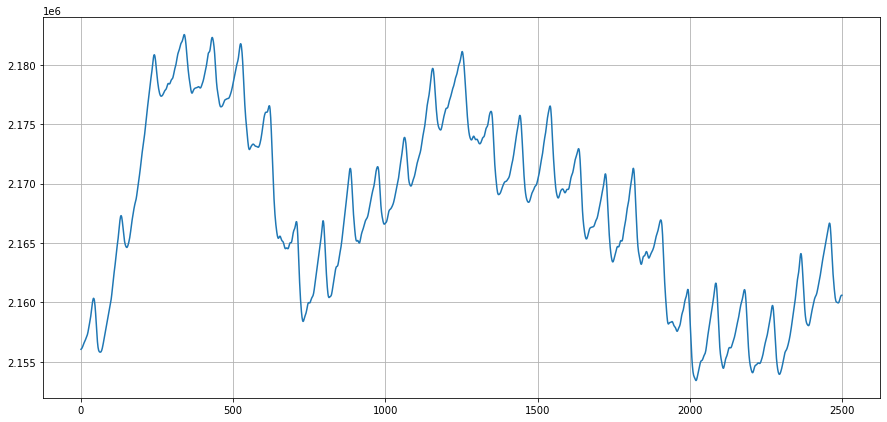

In [7]:
plt.figure(figsize=(15,7))
plt.plot(signals[15])
plt.grid('on')
plt.show()

## Create training data generator

In [16]:
### Normalizing the signal
def normalizer(arr):
    return 2 * ((arr - arr.min()) / (arr.max() - arr.min())) - 1

In [17]:
### Filtering the signal for preprocessing

def butter_filtering(sig,fs,fc,order,btype): 
    '''
    Parameters: sig: signal
    fs: sampling frequency
    fc: cutoff frequencies 
    order: order of the filter
    btype: filter type (e.g., bandpass)
    Returns: 
    filtered: filtered signal
    '''
    w = np.array(fc)/(fs/2)
    b, a = butter(order, w, btype =btype, analog=False)
    filtered = filtfilt(b, a, sig)
    return(filtered)

In [18]:
### Adding noise to the clean PPG signal
def add_noise(noise_signals, downlimit, uplimit):
    # 1. Randomly select one noise signal
    # 2. Randomly select frame from noise signal
    # 3. Multiply noise with some random scalar
    # Return noise
    '''
    Parameters: noise_signals: Noise signal
    downlimit: down limit of uniform distribution for creating a random number to multiply to signal
    uplimit: upper limit of uniform distribution for creating a random number to multiply to signal

    Returns: 
    noise: returning a weighted noise
    
    '''
    random_noise_idx = np.random.randint(0, len(noise_signals))
    random_noise = noise_signals[random_noise_idx]
    noise = random_noise*round(random.uniform(downlimit, uplimit), 5)
    
    return noise

In [19]:
### Checking the Signal-to-noise-ratio (SNR) of the Signal to have balance number if signal with specifice SNR
def SNR_checking(X, y, SNR, SNR_up, SNR_down):
    '''
    Parameters: Check whether the signal is in the desire SNR range
        X: Noisy PPG signal
        y: Label signal
        SNR: SNR of the noisy PPG signal
        SNR_up: Upper range of the SNR
        SNR_down: Lower range of SNR
        
    Returns:
    desire_X: PPG signal which is in the desirable range
    desire_y: Label signal which is in the desirable range
    desire_SNR: The SNR of the PPG signal
    
    '''
    desire_X = []
    desire_y = []
    desire_SNR = []
    
    for i in range(len(SNR)):
        if ((SNR[i] > SNR_down) and (SNR[i] <= SNR_up)):
            
            desire_X.append(X[i])
            desire_y.append(y[i])
            desire_SNR.append(SNR[i])

            
    desire_X = np.asarray(desire_X)
    desire_y = np.asarray(desire_y)
    desire_SNR = np.asarray(desire_SNR)
            
    return desire_X, desire_y, desire_SNR

In [20]:
### Getting the minimum lenght of constructed noisy PPG signal and returning a balance number of noisy PPG signal in desirable SNR range
def Data_extraction(X_inp, y_inp, SNR_inp, min_len):
    '''
    Parameters: 
        X_inp: Noisy PPG signal
        y_inp: Label signal
        SNR_inp: SNR of the noisy PPG signal
        min_len: Minimum number of constructed noisy PPG signal
        
    Returns:
    X_out: PPG signal 
    y_out: Label signal 
    SNR_out: The SNR of the PPG signal
    
    '''
    X_out = []
    y_out = []
    SNR_out = []
    for i in range(len(X_inp)):
        
        X_out.extend(X_inp[i][:min_len])
        y_out.extend(y_inp[i][:min_len])
        SNR_out.extend(SNR_inp[i][:min_len])
        
    return X_out, y_out, SNR_out

In [21]:
### Generating the noisy PPG signal
def ppg_generator(signals, peaks, noise_signals, win_s, sampling_rate, batch_size, return_SNR=False):
    '''
    Parameters: 
        signals: Clean PPG signal
        peaks: location of the clean PPG peaks
        noise_signals: Noise signal
        win_s: Length of the PPG signal
        sampling_rate: Sampling rate of the signal
        batch_size: Size of the batch
        return_SNR: Whether return the value of the SNR or not
        
    Returns:
    X: Noisy PPG signal 
    y: Label signal 
    SNR: The SNR of the PPG signal
    
    '''
    win_size = win_s * sampling_rate
    
    # Number of possible peaks, HR = 200
    num_possible_peaks = int(win_s * (200/60))
    
    while True:
        ### The SNR range and the weighted number that multiply to the noise for scaling the noise
        uplimit_noise =   [4.88, 2.69, 1.50, 0.87, 0.53, 0.35, 0.22,  0.12, 0.065, 0.040, 0.020, 0.013]
        downlimit_noise = [4.65, 2.48, 1.43, 0.79, 0.42, 0.24, 0.14, 0.070, 0.045, 0.024, 0.017, 0.008]
        SNR_range_up =   [-12.5 ,-7.5, -2.5,  2.5,  7.5, 12.5, 17.5,  22.5,   27.5, 32.5, 37.5, 42.5]
        SNR_range_down = [-17.5 ,-12.5,-7.5, -2.5,  2.5,  7.5, 12.5,  17.5,   22.5, 27.5, 32.5, 37.5]
        tot_min = []
        tot_X = []
        tot_y = []
        tot_SNR = []
        
        for i in range(len(downlimit_noise)):
            downlimit = downlimit_noise[i]
            uplimit = uplimit_noise[i]
            down_range = SNR_range_down[i]
            up_range = SNR_range_up[i]
            
            
            X_int = []
            y_int = []
            SNR_int = []

            while len(X_int) < batch_size:
                random_sig_idx = np.random.randint(0, len(signals))
                random_sig = signals[random_sig_idx]
                p4sig = peaks[random_sig_idx]

                # Select one window
                beg = np.random.randint(random_sig.shape[0]-win_size)
                end = beg + win_size

                p_in_win = p4sig[(p4sig >= beg) & (p4sig < end)] - beg

                # Check that there is at least one peak in the window and that amount of peaks is natural
                if (p_in_win.shape[0] >= 1) & (p_in_win.shape[0] <= num_possible_peaks):
                    

                    # ------------- Add noise into training example----------
                    noise = add_noise(noise_signals, downlimit, uplimit)
                    frame = random_sig[beg:end]
                    noise_frame = noise[beg:end]
                    frame_noisy = frame + noise_frame
                    
                    if (p_in_win[-1] <= len(frame_noisy)-4):
                    ####### Filtering thr frame #########
                        filtered_frame = butter_filtering(frame_noisy, sampling_rate, 0.6, 5,'highpass')

                        X_int.append(filtered_frame)
                        ############ Calculating the SNR ###################
                        power_sig = np.trapz(frame**2)/(frame.size/20)
                        power_noise = np.trapz(noise_frame**2)/(noise_frame.size/20)

                        Ratio = 10*np.log10(power_sig/power_noise)

                        SNR_int.append(Ratio)


                        labels = np.zeros(win_size)
                        np.put(labels, [p_in_win-2, p_in_win-1, p_in_win, p_in_win+1, p_in_win+2], [1]);

                        y_int.append(labels)
                    
            X_check, y_check, SNR_check = SNR_checking(X_int, y_int, SNR_int, up_range, down_range)
            
            min_check = len(X_check)
            tot_min.append(min_check)
            tot_X.append(X_check)
            tot_y.append(y_check)
            tot_SNR.append(SNR_check)
     


            
        X, y, SNR = Data_extraction(tot_X, tot_y, tot_SNR, min(tot_min))
        X = np.asarray(X)
        y = np.asarray(y)
        SNR = np.asarray(SNR)


        
        X, y, SNR = shuffle(X, y, SNR,  random_state=0)

        X = np.asarray(X)
        y = np.asarray(y)
        SNR = np.asarray(SNR)


        X = X.reshape(X.shape[0], X.shape[1], 1)
        X = np.apply_along_axis(normalizer, 1, X)
        
        output = (X, y)
        if return_SNR == True:
            output = (X, y, SNR)
        yield output

In [22]:
train_gen = ppg_generator(
    signals=train_signals,
    peaks=train_peaks,
    noise_signals=train_noise,
    win_s=15,
    sampling_rate=100,
    batch_size=100, return_SNR=False
)



test_gen = ppg_generator(
    signals=test_signals,
    peaks=test_peaks,
    noise_signals=test_noise,
    win_s=15,
    sampling_rate=100,
    batch_size=1000, return_SNR=True
)

## Visualize generated data


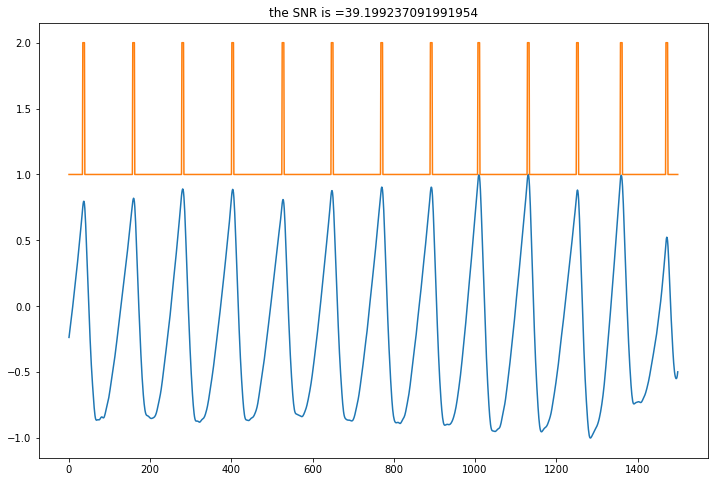

In [28]:
test_X, test_y,SNR = next(test_gen)

plt.figure(figsize = (12,8))
plt.plot(test_X[1])
plt.plot(test_y[1]+1)
plt.title('the SNR is ='+str(SNR[1]))
plt.show()

## Creating and training DCNN model

Tests with dilated CNN (like wavenet, temporal convolutions TCN)

Sequence to sequence model is used to predict R-peak locations. Model takes 1500 time steps of PPG signal as input which are then mapped to 1500 probability values. Each probability value indicates the probability that the particular time step is an R-peak



In [25]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [26]:
with tf.device('/device:GPU:0'):
    iput = tf.keras.layers.Input([1500, 1])
    # x = tf.keras.layers.GaussianNoise(stddev=1)(iput)
    x = Conv1D(kernel_size=3, filters=4, activation="elu", dilation_rate=1, padding='same')(iput)
    x = Conv1D(kernel_size=3, filters=8, activation="elu", dilation_rate=2, padding='same')(x)
    x = Conv1D(kernel_size=3, filters=8, activation="elu", dilation_rate=4, padding='same')(x)
    x = Conv1D(kernel_size=3, filters=16, activation="elu", dilation_rate=8, padding='same')(x)
    x = Conv1D(kernel_size=3, filters=16, activation="elu", dilation_rate=16, padding='same')(x)
    x = Conv1D(kernel_size=3, filters=32, activation="elu", dilation_rate=32, padding='same')(x)
    oput = Conv1D(kernel_size=3, filters=1, activation="sigmoid", dilation_rate=64, padding='same')(x)

    model = tf.keras.Model(inputs=iput, outputs=oput)

    model.compile(
        optimizer='adam',
        loss = 'binary_crossentropy',
        metrics=['accuracy'])

In [27]:
with tf.device('/device:GPU:0'):
    model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1500, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1500, 4)           16        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1500, 8)           104       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1500, 8)           200       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1500, 16)          400       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1500, 16)          784       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1500, 32)          1568  

In [28]:
with tf.device('/device:GPU:0'):
    history = model.fit(train_gen,
                        steps_per_epoch=200,
                        epochs=60)

Epoch 1/60
200/200 [==============================] - 136s 651ms/step - loss: 0.3066 - accuracy: 0.9123
Epoch 2/60
200/200 [==============================] - 125s 623ms/step - loss: 0.1479 - accuracy: 0.9543
Epoch 3/60
200/200 [==============================] - 124s 622ms/step - loss: 0.1352 - accuracy: 0.9603
Epoch 4/60
200/200 [==============================] - 124s 621ms/step - loss: 0.1281 - accuracy: 0.9627
Epoch 5/60
200/200 [==============================] - 124s 620ms/step - loss: 0.1252 - accuracy: 0.9638
Epoch 6/60
200/200 [==============================] - 124s 619ms/step - loss: 0.1220 - accuracy: 0.9649
Epoch 7/60
200/200 [==============================] - 124s 622ms/step - loss: 0.1189 - accuracy: 0.9658
Epoch 8/60
200/200 [==============================] - 124s 618ms/step - loss: 0.1158 - accuracy: 0.9665
Epoch 9/60
200/200 [==============================] - 123s 617ms/step - loss: 0.1133 - accuracy: 0.9670
Epoch 10/60
200/200 [==============================] - 124s 620m

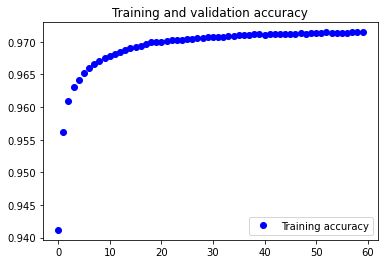

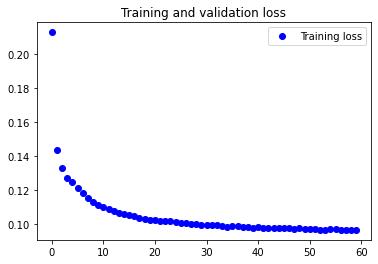

In [32]:
accuracy = history.history['accuracy']
loss = history.history['loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()